In [1]:
%config Completer.use_jedi=False
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from importlib import reload


/Users/wpk/.conda/envs/py37/lib/python3.7/site-packages/distributed/utils.py:138: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  RuntimeWarning,


In [2]:
#import lnPi.old
import lnPi

import lnPi.stability
import lnPi.monoutils

import lnPi2

In [3]:
#function to tag 'LD' and 'HD' phases
def tag_phases2(x):
    if len(x) > 2:
        raise ValueError('bad tag function')
    argmax0 = np.array([xx.local_argmax()[0] for xx in x])
    return np.where(argmax0 <= x[0].shape[0] / 2, 0, 1)


# create a reference lnPi_phases for bulk case

In [4]:
pe = pd.read_csv('./PiofN/ljsf.t070.bulk.v729.r1.energy.dat', header=None, sep='\s+', names=['n','e'])['e'].values

In [5]:
mu = -8.616
volume = 729
temp = 0.7
beta = 1.0 / temp
state_kws = dict(volume=volume, temp=temp, beta=1/temp)
lnz = beta * mu


In [6]:
# reference masked lnPi
ref = lnPi.core.MaskedlnPi.from_table('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat', 
                                      lnz=lnz, state_kws=state_kws, extra_kws={'PE':pe}).zeromax()

# Phase Creator
PhaseCreator = lnPi.segment.PhaseCreator(nmax=2, tag_phases=tag_phases2, nmax_peak=4, merge_kws=dict(efac=0.8), 
                                         ref=ref)
build_phases = PhaseCreator.build_phases

In [7]:
# create a phase object
p = PhaseCreator.build_phases()
p.xgce.betaOmega()

<xarray.DataArray 'betaOmega' (phase: 2)>
array([ -2.554284, -20.713516])
Coordinates:
    lnz_0    float64 -12.31
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
  * phase    (phase) int64 0 1
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'volume', 'temp', 'beta']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

In [11]:
# old
# reference masked lnPi
ref0 = lnPi2.core.MaskedlnPi.from_table('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat', 
                                      mu=mu, state_kws=state_kws, extra_kws={'pe':pe}).zeromax()

# Phase Creator
PhaseCreator0 = lnPi2.segment.PhaseCreator(nmax=2, tag_phases=tag_phases2, nmax_peak=4, merge_kws=dict(efac=0.8), 
                                         ref=ref0)
build_phases0 = PhaseCreator0.build_phases

p0 = PhaseCreator0.build_phases()
p0.xgce.omega().pipe(lambda x: x*x.beta)

<xarray.DataArray (phase: 2)>
array([ -2.554284, -20.713516])
Coordinates:
    mu_0     float64 -8.616
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
  * phase    (phase) int64 0 1

## create a collection

In [12]:
lnzs = np.geomspace(ref.lnz[0] - 5, ref.lnz[0] + 5, 20)
mus = lnzs / beta

# new
# initial pass
c = lnPi.CollectionPhases.from_lnz([None], lnzs, build_phases=PhaseCreator.build_phases)

In [35]:
ref.xgce._co

{'dims_n': ['n_0'],
 'dims_lnz': ['lnz_0'],
 'dims_comp': ['component'],
 'dims_state': ['lnz_0', 'volume', 'temp', 'beta']}

In [34]:
ref.xgce.lnpi

<xarray.DataArray 'lnz_0' ()>
array(-12.308571)
Coordinates:
    lnz_0    float64 -12.31
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
Attributes:
    long_name:  $\beta\mu_0

In [32]:
ref.xgce.betaOmega()

<xarray.DataArray 'betaOmega' ()>
array(-20.713516)
Coordinates:
    lnz_0    float64 -12.31
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'volume', 'temp', 'beta']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

In [30]:
c[0][0].xgce.betaOmega().lnz_0

<xarray.DataArray 'lnz_0' ()>
array(-17.308571)
Coordinates:
    lnz_0    float64 -17.31
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429

In [27]:
c[0].xgce_prop.betaO

<xarray.DataArray 'lnz_0' ()>
array(-17.308571)
Coordinates:
    lnz_0    float64 -17.31
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429

In [25]:
c.xgce_prop.betaOmega().lnz_0

<xarray.DataArray 'lnz_0' (rec: 20)>
array([-17.308571, -16.540722, -15.806935, -15.105702, -14.435576, -13.795179,
       -13.183192, -12.598354, -12.03946 , -11.505361, -10.994955, -10.507193,
       -10.041068,  -9.595622,  -9.169937,  -8.763137,  -8.374383,  -8.002875,
        -7.647848,  -7.308571])
Coordinates:
    lnz_0    (rec) float64 -17.31 -16.54 -15.81 -15.11 ... -8.003 -7.648 -7.309
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

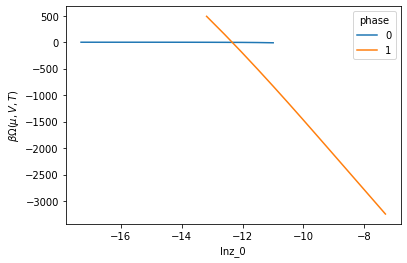

In [23]:
c.xgce_prop.betaOmega().swap_dims({'rec':'lnz_0'}).plot(hue='phase')

In [26]:
t = c.xgce_prop.betaOmega()

In [45]:
c[0][0].xgce.coords_state

{'lnz_0': array(-17.30857143),
 'volume': array(729),
 'temp': array(0.7),
 'beta': array(1.42857143)}

In [ ]:
xr.DataArray()

In [68]:
print(r'${}$'.format(r'\n_0'))

$\n_0$


In [62]:
a = (
    xr.DataArray(np.random.rand(2,2), dims=['lnz_0','lnz_1'], 
                 coords={'lnz_0': xr.DataArray([0,1], dims='lnz_0', attrs={'long_name':r'\beta\mu_0'})} )
    
)



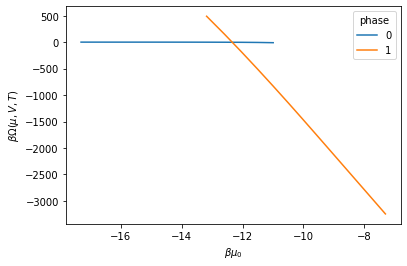

In [39]:
t.assign_coords(lnz_0=t.lnz_0.assign_attrs(long_name=r'$\beta\mu_0$')).swap_dims({'rec':'lnz_0'}).plot(hue='phase')

In [27]:
t.lnz_0.assign_attrs(long_name=r'$\beta\mu_0$')

<xarray.DataArray 'lnz_0' (rec: 20)>
array([-17.308571, -16.540722, -15.806935, -15.105702, -14.435576, -13.795179,
       -13.183192, -12.598354, -12.03946 , -11.505361, -10.994955, -10.507193,
       -10.041068,  -9.595622,  -9.169937,  -8.763137,  -8.374383,  -8.002875,
        -7.647848,  -7.308571])
Coordinates:
    lnz_0    (rec) float64 -17.31 -16.54 -15.81 -15.11 ... -8.003 -7.648 -7.309
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Attributes:
    long_name:  $\beta\mu_0$

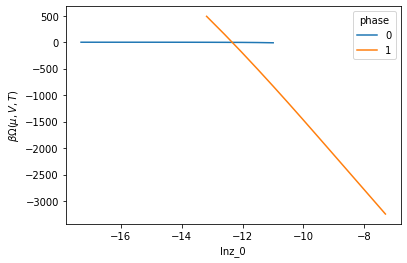

In [21]:
c.xgce_prop.betaOmega().swap_dims({'rec':'lnz_0'}).plot(hue='phase')

In [17]:
c.xgce_prop.table(['betaF_n','dens'], dim_to_suffix='component')

<xarray.Dataset>
Dimensions:  (phase: 2, rec: 20)
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -17.31 -16.54 -15.81 -15.11 ... -8.003 -7.648 -7.309
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    betaF_n  (rec, phase) float64 -18.31 nan -17.54 nan ... -12.23 nan -12.23
    betapV   (rec, phase) float64 0.01666 nan 0.03591 ... nan 3.245e+03
    PE_n     (rec, phase) float64 -0.0002614 nan -0.0005677 ... nan -6.045
    nave_0   (rec, phase) float64 0.01666 nan 0.03593 nan ... 659.9 nan 659.9

In [11]:
spin, _ = c.spinodals(2, build_phases=build_phases, as_dict=False)
bino, _ = c.binodals(2, spinodals=spin, build_phases=build_phases, as_dict=False)

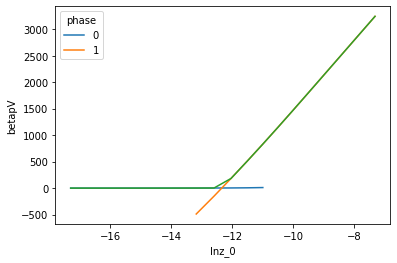

In [54]:
c.xgce_prop.table(dim_to_suffix='component', mask_stable=False).swap_dims({'rec':'lnz_0'}).betapV.plot(hue='phase')
c.xgce_prop.table(dim_to_suffix='component', mask_stable=True).swap_dims({'rec':'lnz_0'}).betapV.plot(hue='phase')

In [56]:
spin.xgce_prop.table(['mask_stable']).rename({'rec':'spin'})#.pipe(lambda x: x.where(~x.mask_stable))

<xarray.Dataset>
Dimensions:      (component: 1, phase: 2, spin: 2)
Coordinates:
    lnz_0        (spin) float64 -10.67 -13.7
    volume       (spin) int64 729 729
    temp         (spin) float64 0.7 0.7
    beta         (spin) float64 1.429 1.429
  * spin         (spin) int64 0 1
  * phase        (phase) int64 0 1
Dimensions without coordinates: component
Data variables:
    mask_stable  (spin, phase) bool False True True False
    nave         (spin, phase, component) float64 23.57 640.4 0.6261 523.7
    betapV       (spin, phase) float64 16.3 1.039e+03 0.6212 -770.3
    PE_n         (spin, phase) float64 -0.4755 -5.912 -0.009935 -4.92

In [58]:
(
    spin.xgce_prop
    .betaOmega()
    .pipe(lambda x: x.where(x.phase == x.rec))
#     .table(['mask_stable']).pipe(lambda x: x.where(~x.mask_stable, drop=True))
#     .swap_dims({'rec':'lnz'})
)


<xarray.DataArray 'betaOmega' (rec: 2, phase: 2)>
array([[-16.299163,        nan],
       [       nan, 770.339413]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -10.67 -13.7
    volume   (rec) int64 729 729
    temp     (rec) float64 0.7 0.7
    beta     (rec) float64 1.429 1.429
  * rec      (rec) int64 0 1
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   beta * Omega(lnz,V,beta)

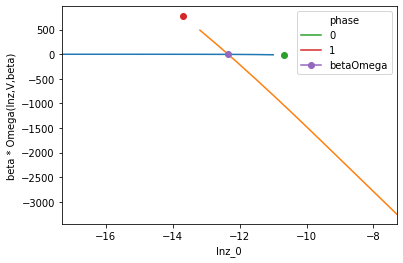

In [59]:
c.xgce.betaOmega().swap_dims({'rec':'lnz_0'}).plot(hue='phase')

(
    spin.xgce.betaOmega()
    .pipe(lambda x: x.where(x.phase == x.rec))
    .swap_dims({'rec':'lnz_0'})
    .plot(hue='phase', marker='o')
)

bino.xgce_prop.betaOmega().sel(phase=0).to_dataframe().plot('lnz_0','betaOmega', marker='o', ax=plt.gca())

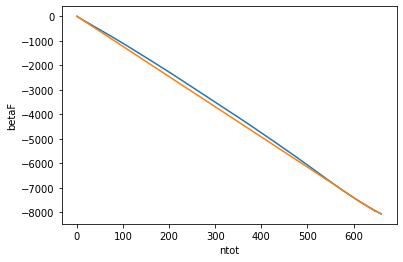

In [30]:
ref.xcan.table(['betaF']).betaF.plot()
c.xgce_prop.table(['betaF','ntot']).sum('phase').set_coords('ntot').swap_dims({'rec':'ntot'}).betaF.plot()

In [8]:
# mu min/max

In [68]:
p_min, r = lnPi.monoutils.get_lnz_min(0.0001, [None], c, build_phases)
p_max, r = lnPi.monoutils.get_lnz_max(8, ref=ref, threshold_abs=1e-4, C=c, build_phases=build_phases)

In [75]:
c = lnPi.CollectionPhases.from_lnz([None], np.linspace(p_min.lnz[0], p_max.lnz[0], 200), 
                                  build_phases=PhaseCreator.build_phases)

In [84]:
c.spinodals(2, build_phases=build_phases, append=True, inplace=True, build_kws=dict(efac=0.5))
c.binodals(2, build_phases=build_phases, append=True, inplace=True, build_kws=dict(efac=0.5))

In [ ]:
# spin, _ = c.spinodals([0,1], build_phases=PhaseCreator.build_phases, build_kws=dict(efac=0.5))
# bino,_ = c.binodals([0,1], spinodals=spin, build_phases=PhaseCreator.build_phases, build_kws=dict(efac=0.5))

In [85]:
c.sort_by_lnz()

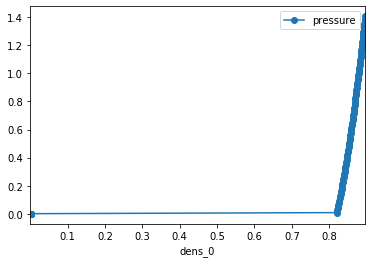

In [94]:
table = c.xgce_prop.table(['dens','pressure'], mask_stable=True, dim_to_suffix='component')
table.to_dataframe().plot('dens_0','pressure', marker='o')

In [15]:
import xarray as xr
@xr.register_dataarray_accessor('lwhere')
def lwhere(da):
    def where(condition, drop=False):
        return da.where(condition(da), drop=drop)
    return where

In [ ]:
# test saving

In [102]:
da = (
    c.to_dataarray()
    .pipe(c.spinodals.assign_coords)
    .pipe(c.binodals.assign_coords)
    .sortby('lnz_0')
    .reset_index('rec', drop=True)
)

In [108]:
c2 = lnPi.CollectionPhases.from_dataarray(ref, da)
c2.spinodals.from_dataarray(da)
c2.binodals.from_dataarray(da)

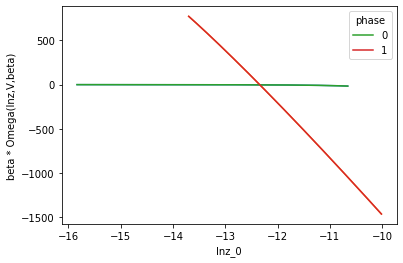

In [118]:
c.xgce.betaOmega().swap_dims({'rec':'lnz_0'}).plot(hue='phase')
c2.xgce.betaOmega().swap_dims({'rec':'lnz_0'}).plot(hue='phase')

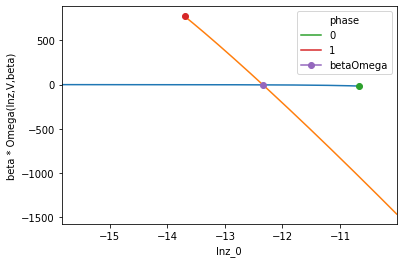

In [130]:
c.xgce.betaOmega().swap_dims({'rec':'lnz_0'}).plot(hue='phase')

(
    c.spinodals.access.xgce.betaOmega()
    .pipe(lambda x: x.where(x.phase == x.rec))
    .swap_dims({'rec':'lnz_0'})
    .plot(hue='phase', marker='o')
)

c.binodals.access.xgce_prop.betaOmega().sel(phase=0).to_dataframe().plot('lnz_0','betaOmega', marker='o', ax=plt.gca())

In [132]:
c.binodals.access.xgce.betaOmega().pipe(lambda x: x / x['beta']).assign_coords(mu_0=lambda x: x['lnz_0'] / x['beta'])

<xarray.DataArray (rec: 1, phase: 2)>
array([[-1.732533, -1.732533]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -12.34
    volume   (rec) int64 729
    temp     (rec) float64 0.7
    beta     (rec) float64 1.429
  * rec      (rec) int64 0
    mu_0     (rec) float64 -8.637

# bulk 065

In [149]:
xx = c[0:10].xgce_prop.betapV()

$$ \ln z $$

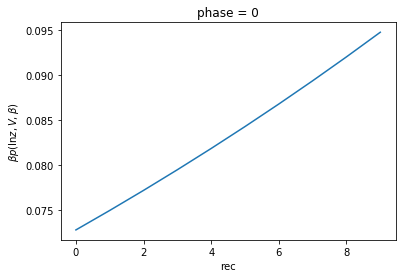

In [154]:
xx.assign_attrs(long_name=r'$\beta p(\lnz, V, \beta)$').plot()

Text(0.5, 0, '$\\beta{\\bf \\mu}$')

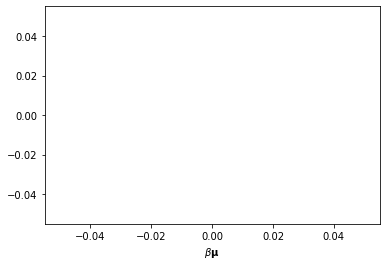

In [138]:
plt.plot([0],[0])
plt.xlabel(r'$\beta{\bf \mu}$')

In [134]:
dens

<xarray.DataArray 'dens' (rec: 203, phase: 2, component: 1)>
array([[[1.000000e-04],
        [         nan]],

       [[1.029724e-04],
        [         nan]],

       ...,

       [[         nan],
        [8.951050e-01]],

       [[         nan],
        [8.957373e-01]]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -15.83 -15.8 -15.78 -15.75 ... -10.07 -10.05 -10.02
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 ... 195 196 197 198 199 200 201 202
Dimensions without coordinates: component
Attributes:
    long_name:  density(component,lnz,V,beta)

In [21]:
base_bulk = lnPi.MaskedlnPi.from_table('./PiofN/ljcut.t065.bulk.v1000.r1.lnpi.dat', mu=-4.453015418106743E+00,
                               state_kws=dict(volume=1000.0E0,beta=1./0.65000E0))

builder_bulk = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=base_bulk, merge_kws=dict(efac=0.5), tag_phases=tag_phases2)

In [23]:
# initial estimate
c_bulk = lnPi.CollectionPhases.from_mu([None], np.linspace(ref.mu[0] - 4, ref.mu[0] + 4, 20), build_phases=builder_bulk.build_phases)
# c_bulk.spinodals(phase_ids=2, build_phases=builder_bulk.build_phases, build_kws=dict(efac=0.5), append=True)
# c_bulk.binodals(phase_ids=2, spinodals=spin, build_phases=builder_bulk.build_phases, build_kws=dict(efac=0.5), append=True)
# c_bulk.sort_by_mu()

# min/max
p_min, r = lnPi.monoutils.get_mu_min(0.0001, [None], c, PhaseCreator.build_phases)
p_max, r = lnPi.monoutils.get_mu_max(10, ref=base_bulk, build_phases=PhaseCreator.build_phases)


# better
c_bulk = lnPi.CollectionPhases.from_mu([None], np.linspace(p_min.mu[0], p_max.mu[0], 200), build_phases=builder_bulk.build_phases)
c_bulk.spinodals(phase_ids=2, build_phases=builder_bulk.build_phases, build_kws=dict(efac=0.5), append=True)
c_bulk.binodals(phase_ids=2, build_phases=builder_bulk.build_phases, build_kws=dict(efac=0.5), append=True)
c_bulk.sort_by_mu()



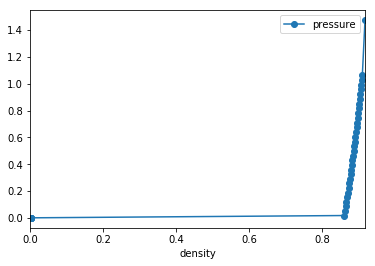

In [24]:
dens = c_bulk.xgce.density
pres = c_bulk.xgce.pressure()

# mask values
mask = pres.pipe(lambda x: x.max('phase') == x)

df = (
    xr.merge((dens, pres))
    .where(mask).max('phase')
    .to_dataframe()
)
    

df.plot('density','pressure',marker='o')

In [25]:
### p.assign_coords(n_0=p.n_0.assign_attrs(long_name='hello'))

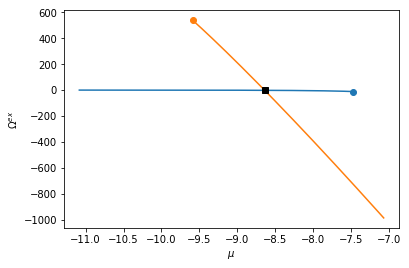

In [26]:
make_omega_vs_mu_phase_plot(c)

# confined

In [27]:
base_conf = lnPi.MaskedlnPi.from_table('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.lnpi.dat',mu=-0.500000E+01,state_kws=dict(volume=7000.,beta=1./0.65000E0))


phasecreator_conf = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=base_conf, merge_kws=dict(efac=0.6), tag_phases=tag_phases2)

build_phases_conf = phasecreator_conf.build_phases





In [94]:
# initial estimate
c_conf = lnPi.CollectionPhases.from_mu([None], np.linspace(base_conf.mu[0] - 5, base_conf.mu[0] + 5, 20), 
                                       build_phases=build_phases_conf, build_phases_kws=(dict(efac=1.0, merge_phase_ids=True)))

# min/max
p_min, r = lnPi.monoutils.get_mu_min(0.0001, [None], c_conf, build_phases_conf)
p_max, r = lnPi.monoutils.get_mu_max(10, ref=base_conf, build_phases=build_phases_conf)

# better estimate
c_conf = lnPi.CollectionPhases.from_mu([None], np.linspace(p_min.mu[0], p_max.mu[0], 200), 
                                       build_phases=build_phases_conf, build_phases_kws=(dict(efac=1.0, merge_phase_ids=True)))




In [95]:
c_conf.spinodals(phase_ids=2, build_phases=build_phases_conf, build_kws=dict(efac=0.5), append=True)
c_conf.binodals(phase_ids=2, build_phases=build_phases_conf, build_kws=dict(efac=0.5), append=True)
c_conf.sort_by_mu()

(-5.14, -5.09)

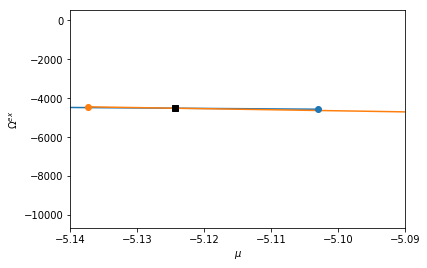

In [96]:
make_omega_vs_mu_phase_plot(c_conf)
plt.xlim(-5.14,-5.09)

In [100]:
df=pd.read_table('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.single_isotherm.txt',sep='\s+',
                 header=None,names=['pscaled','mu','rho','Omega_L','Qst','Gads'])


/Users/wpk/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


# make isotherm

In [101]:
a = np.log(np.linspace(np.exp(-10), np.exp(c_conf.spinodals[1].mu[0]), 50, endpoint=False))

In [110]:
#a = np.linspace(-10,Cconf.spinodals[1].mu[0],200)
b = np.linspace(c_conf.spinodals[1].mu[0],c_conf.spinodals[0].mu[0],50)
c = np.linspace(c_conf.spinodals[0].mu[0],c_bulk.binodals[0].mu[0],50)
mus = np.concatenate((a,b,c))
#mus = c

In [111]:
print(c_conf.mu.max())
print(c_bulk.mu.max())

print(mus.max())

-4.178466796875
-2.8081126966781706
-4.453725936551545


In [112]:
cb = lnPi.core.CollectionPhases.from_mu([None],x=mus, ref=base_bulk, build_phases=builder_bulk.build_phases)
cc = lnPi.core.CollectionPhases.from_mu_iter(cb.mu, ref=base_conf, build_phases=build_phases_conf)

In [118]:
psat = c_bulk.binodals[0].xgce.pressure().sel(phase=0).values

In [119]:
p = cb.xgce.pressure().sel(phase=0) / psat

In [123]:
rho = cc.xgce.nave

In [141]:
iso = xr.merge((p.drop('volume'), rho.drop('volume'))).squeeze().to_dataframe().reset_index()

In [142]:
iso.head()

,phase,rec,mu_0,beta,pressure,nave
0,0,0,-10.000000,1.538462,0.000195,52.806189
1,0,1,-8.728236,1.538462,0.001377,774.982645
2,0,2,-8.186107,1.538462,0.003171,897.867008
3,0,3,-7.836514,1.538462,0.005430,941.621343
4,0,4,-7.577984,1.538462,0.008082,967.917146


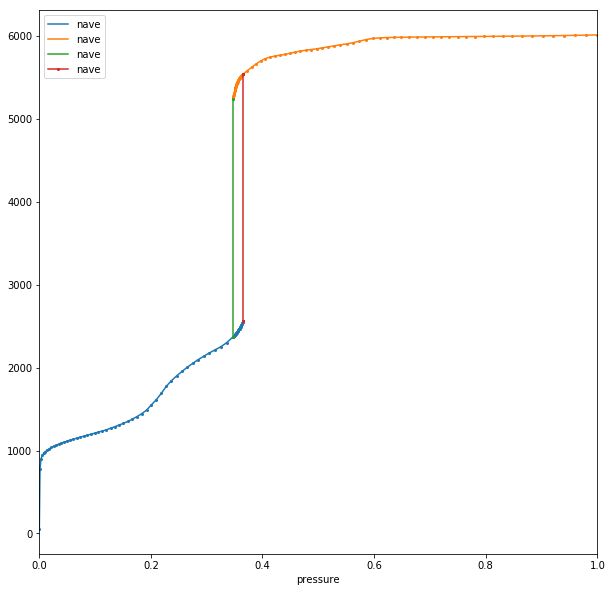

In [148]:
fig,ax = plt.subplots(figsize=(10,10))
for phase, g in iso.groupby('phase'):
    g.plot('pressure','nave', ax=ax,marker='o', ms=2)

iso.query('mu_0==@b[0]').drop_duplicates().plot('pressure','nave', ax=ax, marker='o', ms=2)
iso.query('mu_0==@b[-1]').drop_duplicates().plot('pressure','nave', ax=ax, marker='o', ms=2)

#plt.plot(df.pscaled,df.rho,'--', marker='o', ms=2)
# plt.gca().set_xlim(0,1.0)

(0.3, 0.5)

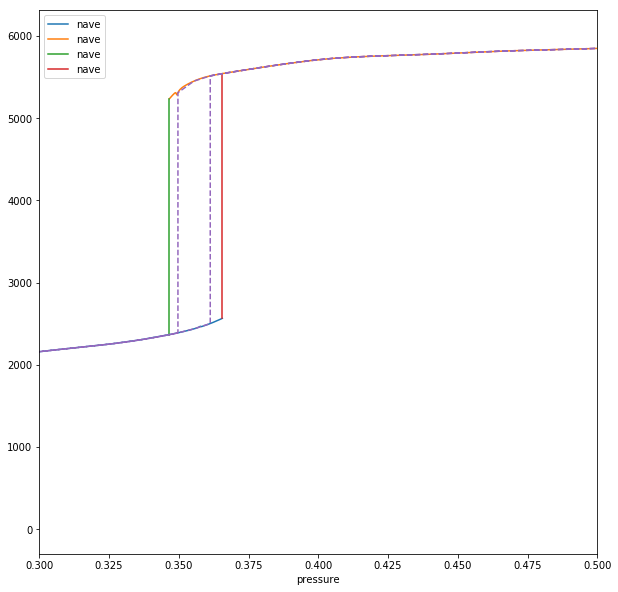

In [146]:
fig,ax = plt.subplots(figsize=(10,10))
for phase, g in iso.groupby('phase'):
    g.plot('pressure','nave', ax=ax)

iso.query('mu_0==@b[0]').drop_duplicates().plot('pressure','nave', ax=ax)
iso.query('mu_0==@b[-1]').drop_duplicates().plot('pressure','nave', ax=ax)

plt.plot(df.pscaled,df.rho,'--')
plt.gca().set_xlim(0.3,0.5)



In [74]:
# hard one